Install + Import Libraries


In [1]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt



In [3]:
df = pd.read_csv("../../data/processed/air_12318_features_sample.csv", on_bad_lines='skip')

Create pseudo-labels (using anomaly score)

In [4]:
df['failure'] = (df['anomaly_score'] == -1).astype(int)


KeyError: 'anomaly_score'

Select Features & Labels

In [ ]:
exclude_cols = ['time', 'anomaly_score', 'failure']
feature_cols = [c for c in df.columns if c not in exclude_cols]

X = df[feature_cols].select_dtypes(include=['number']).fillna(0)
y = df['failure']

Select Features & Labels

In [ ]:
exclude_cols = ['time', 'anomaly_score', 'failure']
feature_cols = [c for c in df.columns if c not in exclude_cols]

X = df[feature_cols].select_dtypes(include=['number']).fillna(0)
y = df['failure']


Train/Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Train XGBoost

In [ ]:
model = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss"
)

model.fit(X_train, y_train)

c:\Users\tiaan\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:13:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

Evaluate

In [ ]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nROC-AUC:", roc_auc_score(y_test, y_proba))


Confusion Matrix:
 [[9999    0]
 [   0    1]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      9999
           1       1.00      1.00      1.00         1

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000


ROC-AUC: 1.0


importance

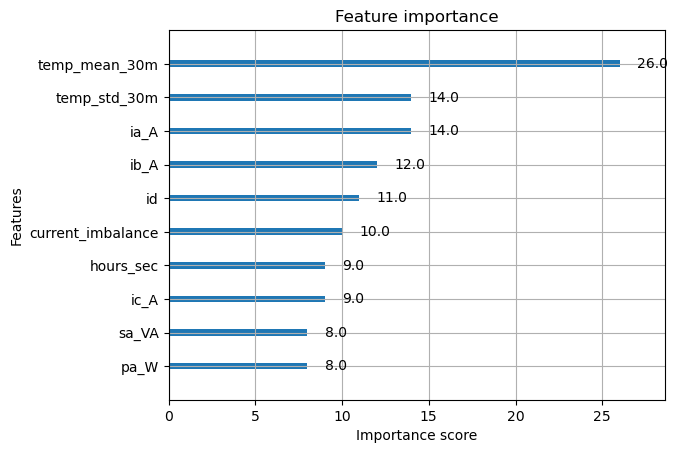

In [ ]:
xgb.plot_importance(model, max_num_features=10)
plt.show()